# Baseline CLIP Evaluation

**This notebook (M0 Baseline):**

* Loads a pre-trained CLIP model (no fine-tuning)
* Computes embeddings for all test images and captions
* Evaluates retrieval performance **at recipe_id level** (multiple valid matches per query):

  * **Text → Image**: one query per recipe using a **representative caption** (longest caption). Ground truth = **all images** with the same `recipe_id`
  * **Image → Text**: one query per image. Ground truth = **all captions** with the same `recipe_id`
* Computes metrics: **R@1, R@5, R@10, MRR, MedianRank (first-hit), MeanRank (first-hit)**
* Tracks performance: **throughput** (images/sec, texts/sec) and **peak VRAM**
* Saves results for comparison with fine-tuned models

**Inputs:**

* `fine-tuning-zone/datasets/test_pairs_positive.csv` (evaluation manifest)
* `fine-tuning-zone/images/` and `fine-tuning-zone/augmented_images/` (images)

**Outputs:**

* `fine-tuning-zone/experiments/baseline/results_baseline.json`
* `fine-tuning-zone/experiments/baseline/examples_top5.json`

## 1. Setup and Configuration


In [4]:
import os
import io
import json
import time
import random
import sys
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from tqdm import tqdm
import yaml

# Load environment variables first (needed for NOTEBOOK_DIR)
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

ENV_PATHS = [
    PROJECT_ROOT / "notebooks" / ".env",
    PROJECT_ROOT / "app" / ".env",
    PROJECT_ROOT / ".env",
]

env_loaded = False
for env_path in ENV_PATHS:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
        env_loaded = True
        break

if not env_loaded:
    print("⚠ No .env file found, trying default load_dotenv()...")
    load_dotenv()

# Load experiment configuration (must be loaded before using CONFIG)
CONFIG_PATH = NOTEBOOK_DIR / "experiment_config.yaml"
if not CONFIG_PATH.exists():
    raise FileNotFoundError(f"Config file not found: {CONFIG_PATH}")

with open(CONFIG_PATH, 'r') as f:
    CONFIG = yaml.safe_load(f)

# Fix random seeds for reproducibility (from config)
RANDOM_SEED = CONFIG["reproducibility"]["random_seed"]
np.random.seed(RANDOM_SEED)
torch.manual_seed(CONFIG["reproducibility"]["torch_seed"])
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["reproducibility"]["torch_seed"])
    # Optional: Enable deterministic mode for GPU (may slow down slightly)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# CLIP imports from transformers
try:
    from transformers import CLIPModel, CLIPProcessor
    import transformers
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    transformers = None
    print("⚠ transformers not available. Install with: pip install transformers")

# MinIO Configuration (from environment)
MINIO_USER = os.getenv("MINIO_USER")
MINIO_PASSWORD = os.getenv("MINIO_PASSWORD")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")

# MinIO configuration (from config)
FINE_TUNING_BUCKET = CONFIG["minio"]["bucket"]
DATASETS_PREFIX = CONFIG["minio"]["prefixes"]["datasets"]
IMAGES_PREFIX = CONFIG["minio"]["prefixes"]["images"]
EXPERIMENTS_PREFIX = CONFIG["minio"]["prefixes"]["experiments"]

# Dataset configuration (from config)
TEST_MANIFEST_KEY = CONFIG["dataset"]["test_manifest_key"]

# Model configuration (from config)
MODEL_NAME = CONFIG["model"]["name"]

# Device selection (robust - test if CUDA actually works)
def pick_device():
    """Pick device, testing if CUDA actually works (not just available)."""
    device_config = CONFIG["model"].get("device")
    if device_config:
        # If config specifies device, test it if it's CUDA
        if device_config == "cuda":
            if not torch.cuda.is_available():
                print("⚠ Config specifies 'cuda' but CUDA is not available. Using CPU.")
                return "cpu"
            try:
                _ = torch.randn(1, device="cuda")
                return "cuda"
            except Exception as e:
                print(f"⚠ Config specifies 'cuda' but CUDA is not usable: {e}. Using CPU.")
                return "cpu"
        return device_config
    
    # Auto-detect: test if CUDA actually works
    if not torch.cuda.is_available():
        return "cpu"
    try:
        _ = torch.randn(1, device="cuda")
        return "cuda"
    except Exception as e:
        print(f"⚠ CUDA visible pero no usable: {e}")
        return "cpu"

DEVICE = pick_device()
BATCH_SIZE = CONFIG["model"]["batch_size"]

# Evaluation configuration (from config)
K_VALUES = CONFIG["evaluation"]["k_values"]
COMPUTE_MRR = CONFIG["evaluation"]["compute_mrr"]

# Experiment configuration (from config)
METHOD = CONFIG["experiment"]["method"]
RESULTS_DIR_BASE = CONFIG["experiment"]["results_dir"]

# Output paths
RUN_ID = f"{METHOD}_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')}"
RESULTS_DIR = f"{RESULTS_DIR_BASE}/{METHOD}"
RESULTS_KEY = f"{RESULTS_DIR}/results_{METHOD}.json"
EXAMPLES_KEY = f"{RESULTS_DIR}/examples_top5.json"

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {DEVICE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  K values: {K_VALUES}")
print(f"  Run ID: {RUN_ID}")


✓ Loaded .env from: /home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/notebooks/.env
Configuration:
  Model: openai/clip-vit-base-patch32
  Device: cuda
  Batch Size: 32
  K values: [1, 5, 10]
  Run ID: baseline_20260104_192432


## 2. Initialize MinIO Client


In [5]:
# Initialize S3/MinIO client
session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)

def ensure_bucket_exists(bucket: str) -> bool:
    """Create bucket if it doesn't exist."""
    try:
        s3.head_bucket(Bucket=bucket)
        return True
    except ClientError as e:
        error_code = e.response.get("Error", {}).get("Code", "")
        if error_code in ("404", "NoSuchBucket"):
            try:
                s3.create_bucket(Bucket=bucket)
                print(f"✓ Created bucket '{bucket}'")
                return True
            except ClientError as create_error:
                print(f"✗ Failed to create bucket '{bucket}': {create_error}")
                return False
        return False

# Verify buckets
print("Checking buckets...")
ensure_bucket_exists(FINE_TUNING_BUCKET)
print("✓ Buckets ready")


Checking buckets...
✓ Buckets ready


## 3. Load Test Dataset


In [6]:
def load_csv_from_minio(bucket: str, key: str) -> pd.DataFrame:
    """Load CSV file from MinIO into a DataFrame."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(io.BytesIO(obj["Body"].read()))
        print(f"✓ Loaded {len(df)} rows from s3://{bucket}/{key}")
        return df
    except ClientError as e:
        print(f"✗ Failed to load s3://{bucket}/{key}: {e}")
        return pd.DataFrame()

# Load test manifest
print("Loading test manifest...")
test_df = load_csv_from_minio(FINE_TUNING_BUCKET, TEST_MANIFEST_KEY)

if test_df.empty:
    raise RuntimeError(f"Could not load test manifest from s3://{FINE_TUNING_BUCKET}/{TEST_MANIFEST_KEY}")

print(f"\nTest dataset shape: {test_df.shape}")
print(f"Unique recipes: {test_df['recipe_id'].nunique()}")
print(f"Unique images: {test_df['image_key'].nunique()}")
print(f"Unique captions: {test_df['caption'].nunique()}")

print(f"\nTest dataset preview:")
display(test_df.head())


Loading test manifest...
✓ Loaded 97 rows from s3://fine-tuning-zone/datasets/test_pairs_positive.csv

Test dataset shape: (97, 3)
Unique recipes: 54
Unique images: 97
Unique captions: 54

Test dataset preview:


,recipe_id,image_key,caption
0,004a63989e,images/image$adsdb-multimodal-food-data-manage...,Lighter Spicy Garlic Shrimp
1,002481e577,images/image$adsdb-multimodal-food-data-manage...,Quick & Easy Chicken Parmigiana
2,002481e577,images/image$adsdb-multimodal-food-data-manage...,Quick & Easy Chicken Parmigiana
3,002481e577,images/image$adsdb-multimodal-food-data-manage...,Quick & Easy Chicken Parmigiana
4,0044818076,images/image$adsdb-multimodal-food-data-manage...,Noodles With Spicy Peanut Sauce


## 4. Load CLIP Model


In [7]:
if not TRANSFORMERS_AVAILABLE:
    raise ImportError("transformers library not available. Install with: pip install transformers")

print(f"Loading CLIP model: {MODEL_NAME}")
print(f"Device: {DEVICE}")

# Load processor and model from transformers
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()  # Set to evaluation mode

# Get model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model is frozen (baseline, no fine-tuning)")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIP model: openai/clip-vit-base-patch32
Device: cuda

✓ Model loaded successfully
  Total parameters: 151,277,313
  Trainable parameters: 151,277,313
  Model is frozen (baseline, no fine-tuning)


## 5. Helper Functions for MinIO Image Loading


In [8]:
def load_image_from_minio(bucket: str, key: str) -> Optional[Image.Image]:
    """Load an image from MinIO."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read()))
        img.load()
        return img.convert("RGB")
    except Exception as e:
        print(f"⚠ Failed to load image {key}: {e}")
        return None

def get_image_path_in_minio(image_key: str) -> Tuple[str, str]:
    """
    Determine bucket and full key for an image.
    
    Images can be in:
    - fine-tuning-zone/images/...
    - fine-tuning-zone/augmented_images/...
    
    Tries images/ first, then augmented_images/ if not found.
    """
    bucket = FINE_TUNING_BUCKET
    
    # Check if it's already a full path
    if image_key.startswith("images/") or image_key.startswith("augmented_images/"):
        key = image_key
    else:
        # Try images/ first
        key = f"{IMAGES_PREFIX}/{image_key}"
        # Check if exists, if not try augmented_images/
        try:
            s3.head_object(Bucket=bucket, Key=key)
        except ClientError as e:
            if e.response.get("Error", {}).get("Code") == "404":
                # Try augmented_images/
                key = f"augmented_images/{image_key}"
            else:
                raise
    
    return bucket, key


## 6. Generate Embeddings


In [9]:
def generate_image_embeddings(
    df: pd.DataFrame, 
    model, 
    processor, 
    device: str, 
    batch_size: int = 32
) -> Tuple[np.ndarray, List[str], List[str]]:
    """
    Generate image embeddings for all images in the dataset.
    
    Returns:
        embeddings: numpy array of shape (n_images, embedding_dim)
        image_keys: list of image keys in the same order
        failed_keys: list of image keys that failed to load
    """
    model.eval()
    embeddings = []
    image_keys = []
    failed_keys = []
    
    # Get unique images
    unique_images = df["image_key"].unique()
    
    print(f"Generating embeddings for {len(unique_images)} unique images...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(unique_images), batch_size)):
            batch_keys = unique_images[i:i+batch_size]
            batch_images = []
            valid_keys = []
            
            # Load batch of images
            for img_key in batch_keys:
                bucket, key = get_image_path_in_minio(img_key)
                img = load_image_from_minio(bucket, key)
                if img is not None:
                    batch_images.append(img)
                    valid_keys.append(img_key)
                else:
                    failed_keys.append(img_key)
            
            if not batch_images:
                continue
            
            # Process images with processor
            inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)
            
            # Get image embeddings
            outputs = model.get_image_features(**inputs)
            batch_emb = F.normalize(outputs, p=2, dim=1)  # L2 normalize
            
            embeddings.append(batch_emb.cpu().numpy())
            image_keys.extend(valid_keys)
    
    if failed_keys:
        print(f"⚠ Failed to load {len(failed_keys)} images")
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(image_keys)} image embeddings (shape: {embeddings.shape})")
    
    return embeddings, image_keys, failed_keys

def generate_text_embeddings(
    texts: List[str], 
    model, 
    processor, 
    device: str, 
    batch_size: int = 32
) -> np.ndarray:
    """
    Generate text embeddings for all captions.
    
    Returns:
        embeddings: numpy array of shape (n_texts, embedding_dim)
    """
    model.eval()
    embeddings = []
    
    print(f"Generating embeddings for {len(texts)} texts...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            
            # Process texts with processor
            inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
            
            # Get text embeddings
            outputs = model.get_text_features(**inputs)
            batch_emb = F.normalize(outputs, p=2, dim=1)  # L2 normalize
            
            embeddings.append(batch_emb.cpu().numpy())
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(texts)} text embeddings (shape: {embeddings.shape})")
    
    return embeddings

# Generate embeddings
print("=" * 60)
print("Generating Embeddings")
print("=" * 60)

# Reset CUDA memory stats if using GPU
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

# Image embeddings (measure time separately)
image_start_time = time.time()
image_embeddings, image_keys, failed_image_keys = generate_image_embeddings(
    test_df, model, processor, DEVICE, BATCH_SIZE
)
image_time = time.time() - image_start_time

# Text embeddings (measure time separately)
text_start_time = time.time()
unique_captions = test_df["caption"].unique().tolist()
text_embeddings = generate_text_embeddings(unique_captions, model, processor, DEVICE, BATCH_SIZE)
text_time = time.time() - text_start_time

embedding_time = image_time + text_time

# Compute throughput and memory metrics (separate for images and texts)
n_images = len(image_keys)
n_texts = len(unique_captions)
images_per_sec = n_images / image_time if image_time > 0 else 0
texts_per_sec = n_texts / text_time if text_time > 0 else 0

memory_metrics = {}
if torch.cuda.is_available():
    peak_memory_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB
    memory_metrics = {
        "peak_vram_mb": peak_memory_mb,
        "peak_vram_gb": peak_memory_mb / 1024
    }

print(f"\n✓ Embedding generation complete in {embedding_time:.2f} seconds")
print(f"  Image embeddings: {image_embeddings.shape}")
print(f"  Text embeddings: {text_embeddings.shape}")
print(f"  Throughput: {images_per_sec:.1f} images/sec, {texts_per_sec:.1f} texts/sec")
if memory_metrics:
    print(f"  Peak VRAM: {memory_metrics['peak_vram_mb']:.1f} MB ({memory_metrics['peak_vram_gb']:.2f} GB)")

# Create mapping dictionaries for lookup
image_key_to_idx = {key: idx for idx, key in enumerate(image_keys)}
caption_to_idx = {caption: idx for idx, caption in enumerate(unique_captions)}

# Precompute lookup dictionaries for O(1) access (optimization)
print("\nPrecomputing lookup dictionaries...")

# recipe_id -> list of image indices
# Convert recipe_id to string for consistency (pandas can return int64)
recipe_to_image_indices: Dict[str, List[int]] = {}
for recipe_id in test_df["recipe_id"].unique():
    recipe_id_str = str(recipe_id)
    recipe_images = test_df[test_df["recipe_id"] == recipe_id]["image_key"].unique()
    recipe_to_image_indices[recipe_id_str] = [
        image_key_to_idx.get(img_key) 
        for img_key in recipe_images 
        if image_key_to_idx.get(img_key) is not None
    ]

# recipe_id -> list of caption indices (one caption per recipe for text→image query)
# Use longest caption as representative (most informative)
recipe_to_caption_indices: Dict[str, List[int]] = {}
recipe_to_caption_text: Dict[str, str] = {}
# recipe_id -> list of ALL caption indices (for image→text ground truth)
recipe_to_all_caption_indices: Dict[str, List[int]] = {}
for recipe_id in test_df["recipe_id"].unique():
    recipe_id_str = str(recipe_id)
    recipe_captions = test_df[test_df["recipe_id"] == recipe_id]["caption"].unique()
    if len(recipe_captions) == 0:
        continue
    
    # Use longest caption as representative (most informative)
    # If multiple have same length, use first after sorting alphabetically (deterministic)
    representative_caption = max(recipe_captions, key=lambda c: (len(c), c))
    
    # Store representative caption for text→image queries
    cap_idx = caption_to_idx.get(representative_caption)
    if cap_idx is not None:
        recipe_to_caption_indices[recipe_id_str] = [cap_idx]
        recipe_to_caption_text[recipe_id_str] = representative_caption
    
    # Store ALL captions for image→text ground truth (more fair if multiple captions per recipe)
    all_caption_indices = []
    for caption in recipe_captions:
        cap_idx = caption_to_idx.get(caption)
        if cap_idx is not None:
            all_caption_indices.append(cap_idx)
    recipe_to_all_caption_indices[recipe_id_str] = list(set(all_caption_indices))  # Remove duplicates

# image_key -> recipe_id (as string for consistency)
image_key_to_recipe_id: Dict[str, str] = {}
for _, row in test_df.iterrows():
    if row["image_key"] not in image_key_to_recipe_id:
        image_key_to_recipe_id[row["image_key"]] = str(row["recipe_id"])

print(f"✓ Precomputed lookups for {len(recipe_to_image_indices)} recipes")


Generating Embeddings
Generating embeddings for 97 unique images...


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


✓ Generated 97 image embeddings (shape: (97, 512))
Generating embeddings for 54 texts...


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

✓ Generated 54 text embeddings (shape: (54, 512))

✓ Embedding generation complete in 3.43 seconds
  Image embeddings: (97, 512)
  Text embeddings: (54, 512)
  Throughput: 31.4 images/sec, 158.1 texts/sec
  Peak VRAM: 679.7 MB (0.66 GB)

Precomputing lookup dictionaries...
✓ Precomputed lookups for 54 recipes


## 7. Evaluation Functions


In [10]:
def compute_recall_at_k(scores: np.ndarray, ground_truth_indices: List[int], k: int) -> float:
    """
    Compute Recall@K.
    
    Args:
        scores: similarity scores for all candidates (1D array)
        ground_truth_indices: list of correct candidate indices
        k: top-K to consider
    
    Returns:
        recall@k: 1.0 if any ground truth is in top-K, else 0.0
    """
    if len(ground_truth_indices) == 0:
        return 0.0
    
    top_k_indices = np.argsort(scores)[-k:][::-1]  # Top K, highest first
    top_k_set = set(top_k_indices)
    
    # Check if any ground truth is in top-K
    for gt_idx in ground_truth_indices:
        if gt_idx in top_k_set:
            return 1.0
    
    return 0.0

def compute_mrr(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """
    Compute Mean Reciprocal Rank.
    
    Args:
        scores: similarity scores for all candidates (1D array)
        ground_truth_indices: list of correct candidate indices
    
    Returns:
        mrr: 1/rank of first correct result, or 0.0 if none found
    """
    if len(ground_truth_indices) == 0:
        return 0.0
    
    # Sort by score (descending)
    sorted_indices = np.argsort(scores)[::-1]
    
    # Find rank of first ground truth
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return 1.0 / rank
    
    return 0.0

def compute_first_hit_rank(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """
    Compute rank of first correct result (first hit rank).
    
    Args:
        scores: similarity scores for all candidates (1D array)
        ground_truth_indices: list of correct candidate indices
    
    Returns:
        first_hit_rank: rank of first correct result (1-indexed), or len(scores)+1 if not found
    """
    if len(ground_truth_indices) == 0:
        return float(len(scores) + 1)
    
    # Sort by score (descending)
    sorted_indices = np.argsort(scores)[::-1]
    
    # Find rank of first ground truth
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return float(rank)
    
    return float(len(scores) + 1)  # Not found

def evaluate_text_to_image_by_recipe(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_indices: Dict[str, List[int]],
    recipe_to_image_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    k_values: List[int],
    should_compute_mrr: bool = True,
    should_compute_median_rank: bool = True
) -> Dict:
    """
    Evaluate Text → Image retrieval by recipe_id.
    
    For each recipe_id, use its representative caption to retrieve images.
    Ground truth: all images from that recipe_id.
    """
    print("\nEvaluating Text → Image retrieval (by recipe_id)...")
    
    unique_recipe_ids = test_df["recipe_id"].unique()
    
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    median_ranks = [] if should_compute_median_rank else None
    
    for recipe_id in tqdm(unique_recipe_ids, desc="Processing recipes"):
        recipe_id_str = str(recipe_id)
        # Get representative caption embedding (first caption for this recipe)
        caption_indices = recipe_to_caption_indices.get(recipe_id_str, [])
        if not caption_indices:
            continue
        
        # Use first caption (or could average multiple)
        text_idx = caption_indices[0]
        text_emb = text_embeddings[text_idx]
        
        # Compute similarities with all images
        similarities = image_embeddings @ text_emb  # (n_images,)
        
        # Get ground truth: all images from this recipe_id
        ground_truth_indices = recipe_to_image_indices.get(recipe_id_str, [])
        ground_truth_indices = [idx for idx in ground_truth_indices if idx is not None]
        
        if len(ground_truth_indices) == 0:
            continue
        
        # Compute metrics
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
        
        if should_compute_median_rank:
            first_hit_rank = compute_first_hit_rank(similarities, ground_truth_indices)
            median_ranks.append(first_hit_rank)
    
    # Average metrics
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    
    if should_compute_median_rank and median_ranks:
        results["MedianRank_first_hit"] = float(np.median(median_ranks))
        results["MeanRank_first_hit"] = float(np.mean(median_ranks))
    
    return results

def evaluate_image_to_text_by_recipe(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    k_values: List[int],
    should_compute_mrr: bool = True,
    should_compute_median_rank: bool = True
) -> Dict:
    """
    Evaluate Image → Text retrieval by recipe_id.
    
    For each image, retrieve captions. Ground truth: ALL captions from the same recipe_id.
    """
    print("\nEvaluating Image → Text retrieval (by recipe_id)...")
    
    unique_images = test_df["image_key"].unique()
    
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    median_ranks = [] if should_compute_median_rank else None
    
    for img_key in tqdm(unique_images, desc="Processing images"):
        # Get image embedding
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        
        img_emb = image_embeddings[img_idx]
        
        # Compute similarities with all captions
        similarities = text_embeddings @ img_emb  # (n_texts,)
        
        # Get recipe_id for this image
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        if not recipe_id_str:
            continue
        
        # Get ground truth: ALL captions from the same recipe_id (more fair)
        ground_truth_indices = recipe_to_all_caption_indices.get(recipe_id_str, [])
        ground_truth_indices = [idx for idx in ground_truth_indices if idx is not None]
        
        if len(ground_truth_indices) == 0:
            continue
        
        # Compute metrics
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
        
        if should_compute_median_rank:
            first_hit_rank = compute_first_hit_rank(similarities, ground_truth_indices)
            median_ranks.append(first_hit_rank)
    
    # Average metrics
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    
    if should_compute_median_rank and median_ranks:
        results["MedianRank_first_hit"] = float(np.median(median_ranks))
        results["MeanRank_first_hit"] = float(np.mean(median_ranks))
    
    return results


In [11]:
print("=" * 60)
print("Running Evaluation")
print("=" * 60)

eval_start_time = time.time()

# Text → Image retrieval (by recipe_id)
text_to_image_results = evaluate_text_to_image_by_recipe(
    test_df,
    text_embeddings,
    image_embeddings,
    recipe_to_caption_indices,
    recipe_to_image_indices,
    image_key_to_idx,
    K_VALUES,
    COMPUTE_MRR,
    should_compute_median_rank=True
)

# Image → Text retrieval (by recipe_id)
image_to_text_results = evaluate_image_to_text_by_recipe(
    test_df,
    text_embeddings,
    image_embeddings,
    recipe_to_all_caption_indices,
    image_key_to_idx,
    image_key_to_recipe_id,
    K_VALUES,
    COMPUTE_MRR,
    should_compute_median_rank=True
)

eval_time = time.time() - eval_start_time

print("\n" + "=" * 60)
print("Evaluation Results")
print("=" * 60)

# Mapping for display names (only for specific metrics)
METRIC_DISPLAY_NAMES = {
    "MedianRank_first_hit": "MedianRank",
    "MeanRank_first_hit": "MeanRank"
}

print("\n📊 Text → Image Retrieval:")
for metric, value in text_to_image_results.items():
    # Display with shorter names for readability (only for specific metrics)
    display_name = METRIC_DISPLAY_NAMES.get(metric, metric)
    # Format ranks with 2 decimals, other metrics with 4 decimals
    if metric in ("MedianRank_first_hit", "MeanRank_first_hit"):
        print(f"  {display_name}: {value:.2f}")
    else:
        print(f"  {display_name}: {value:.4f}")

print("\n📊 Image → Text Retrieval:")
for metric, value in image_to_text_results.items():
    # Display with shorter names for readability (only for specific metrics)
    display_name = METRIC_DISPLAY_NAMES.get(metric, metric)
    # Format ranks with 2 decimals, other metrics with 4 decimals
    if metric in ("MedianRank_first_hit", "MeanRank_first_hit"):
        print(f"  {display_name}: {value:.2f}")
    else:
        print(f"  {display_name}: {value:.4f}")

print(f"\n⏱ Evaluation time: {eval_time:.2f} seconds")


Running Evaluation

Evaluating Text → Image retrieval (by recipe_id)...


Processing recipes: 100%|██████████| 54/54 [00:00<00:00, 10056.94it/s]



Evaluating Image → Text retrieval (by recipe_id)...


Processing images: 100%|██████████| 97/97 [00:00<00:00, 19946.44it/s]


Evaluation Results

📊 Text → Image Retrieval:
  R@1: 0.6667
  R@5: 0.9074
  R@10: 0.9444
  MRR: 0.7759
  MedianRank: 1.00
  MeanRank: 2.70

📊 Image → Text Retrieval:
  R@1: 0.7320
  R@5: 0.9278
  R@10: 0.9588
  MRR: 0.8272
  MedianRank: 1.00
  MeanRank: 2.66

⏱ Evaluation time: 0.02 seconds


## 8. Visualize Retrieval Results

Visualize qualitative examples showing top-5 retrievals for both directions:
- **Text → Image**: Show the 5 most similar images for sample captions
- **Image → Text**: Show the 5 most similar captions for sample images


Visualizing Retrieval Results

📝 Text → Image Retrieval (Top-5 images for each recipe):
------------------------------------------------------------


/tmp/ipykernel_81931/2929936790.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


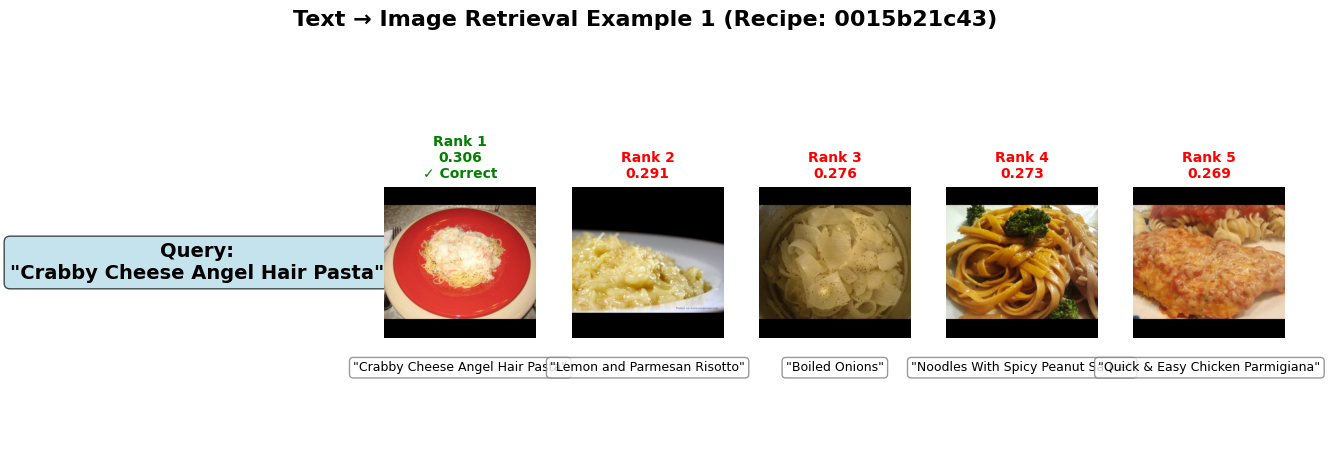

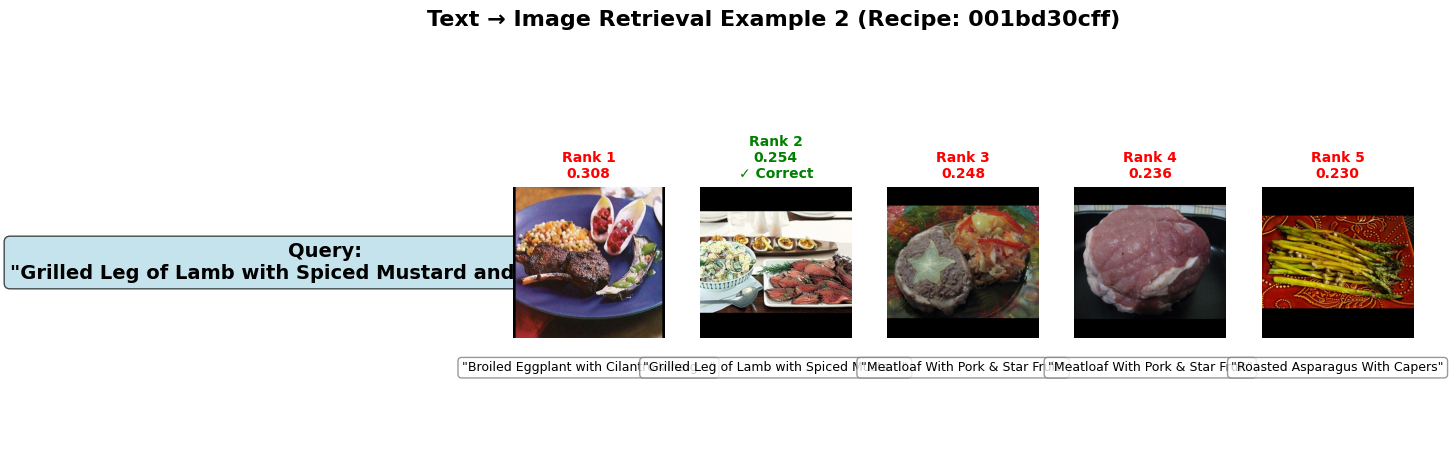

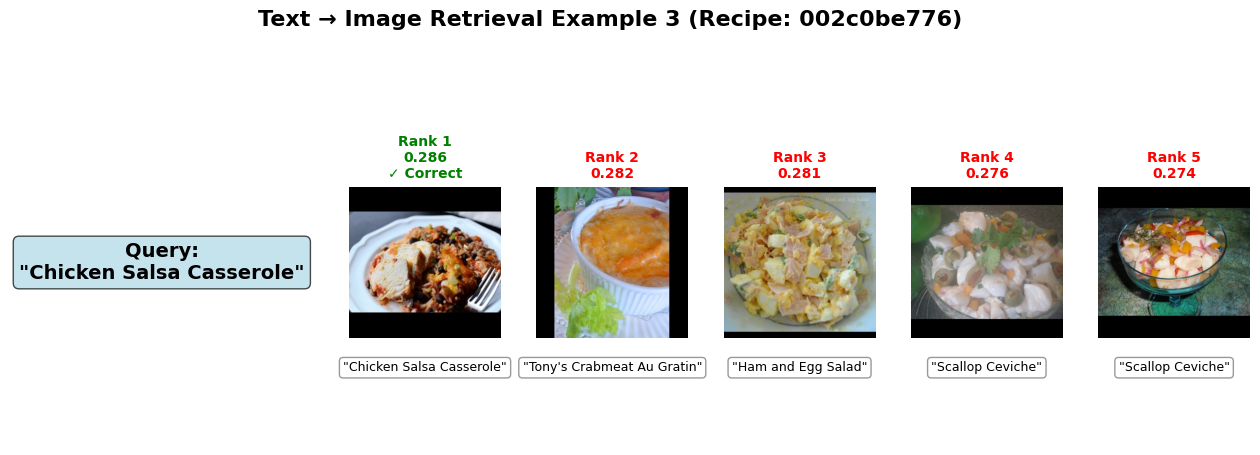



🖼️ Image → Text Retrieval (Top-5 captions for each image):
------------------------------------------------------------


/tmp/ipykernel_81931/2929936790.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


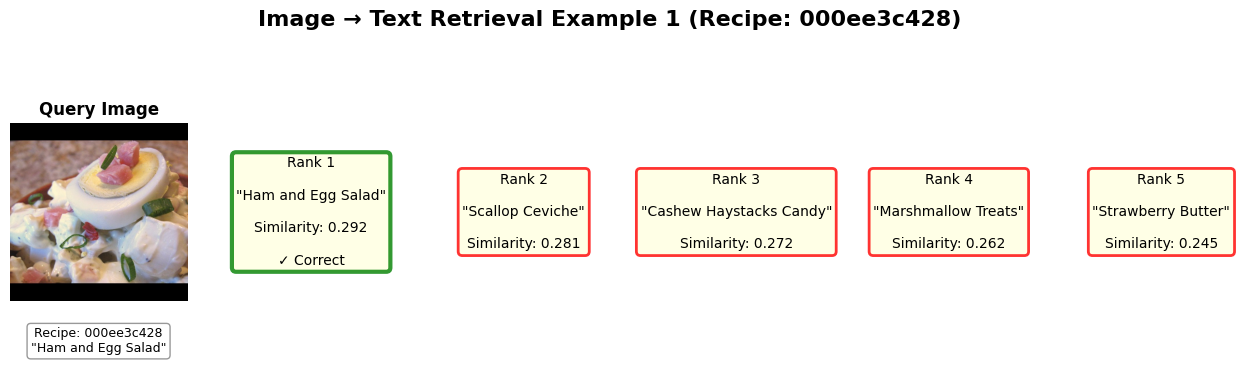

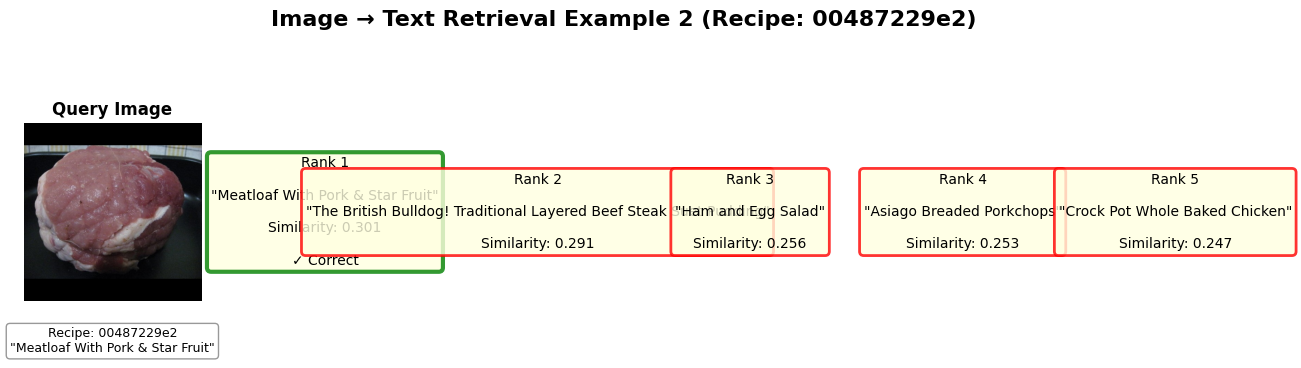

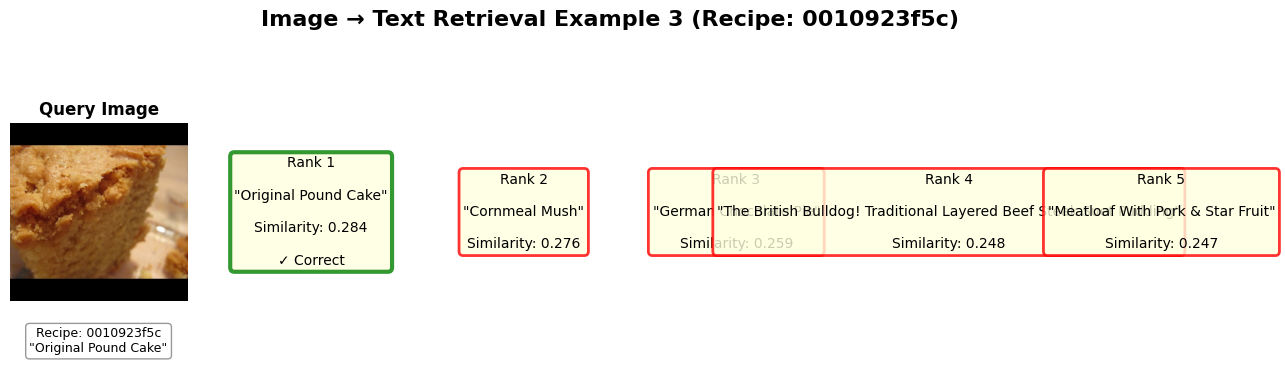

In [12]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def visualize_text_to_image_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_text: Dict[str, str],
    recipe_to_image_indices: Dict[str, List[int]],
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    n_examples: int = 3
):
    """
    Visualize Text → Image retrieval: for each recipe, show top-5 images.
    """
    # Sample random recipes
    unique_recipe_ids = test_df["recipe_id"].unique()
    sample_recipe_ids = pd.Series(unique_recipe_ids).sample(
        min(n_examples, len(unique_recipe_ids)),
        random_state=RANDOM_SEED
    )
    
    for recipe_idx, recipe_id in enumerate(sample_recipe_ids):
        recipe_id_str = str(recipe_id)
        # Get representative caption for this recipe
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        
        # Get caption embedding
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]  # Top 5, highest first
        
        # Get ground truth: images from this recipe_id
        gt_image_indices = set(recipe_to_image_indices.get(recipe_id_str, []))
        
        # Create figure with more vertical space for captions
        fig = plt.figure(figsize=(16, 5))
        gs = gridspec.GridSpec(1, 6, width_ratios=[2, 1, 1, 1, 1, 1], hspace=0.3, bottom=0.15)
        
        # Show query caption
        ax0 = fig.add_subplot(gs[0])
        ax0.text(0.5, 0.5, f'Query:\n"{caption}"', 
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax0.axis('off')
        
        # Show top-5 images
        for i, img_idx in enumerate(top5_indices):
            img_key = image_keys[img_idx]
            bucket, key = get_image_path_in_minio(img_key)
            img = load_image_from_minio(bucket, key)
            
            if img is None:
                continue
            
            # Check if this image is from the ground truth recipe
            is_correct = img_idx in gt_image_indices
            
            # Get recipe_id for this image to show its representative caption
            img_recipe_id = image_key_to_recipe_id.get(img_key, "Unknown")
            # Note: Shows representative caption of the recipe (longest caption), not necessarily the exact caption for this image
            img_caption = recipe_to_caption_text.get(img_recipe_id, "Unknown")
            
            ax = fig.add_subplot(gs[i + 1])
            ax.imshow(img)
            ax.axis('off')
            
            # Color border: green if correct, red if incorrect
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(border_width)
            
            # Title with similarity score
            similarity_score = similarities[img_idx]
            rank = i + 1
            title = f"Rank {rank}\n{similarity_score:.3f}"
            if is_correct:
                title += "\n✓ Correct"
            ax.set_title(title, fontsize=10, color=border_color, fontweight='bold')
            
            # Add recipe caption below the image
            # Truncate long captions for display
            display_caption = img_caption if len(img_caption) <= 40 else img_caption[:37] + "..."
            ax.text(0.5, -0.15, f'"{display_caption}"', 
                   ha='center', va='top', fontsize=9, 
                   transform=ax.transAxes,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                   wrap=True)
        
        plt.suptitle(f'Text → Image Retrieval Example {recipe_idx + 1} (Recipe: {recipe_id_str})', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print()

def visualize_image_to_text_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    recipe_to_caption_text: Dict[str, str],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    n_examples: int = 3
):
    """
    Visualize Image → Text retrieval: for each image, show top-5 captions.
    """
    # Sample random images
    unique_images = test_df["image_key"].unique()
    sample_images = pd.Series(unique_images).sample(
        min(n_examples, len(unique_images)),
        random_state=RANDOM_SEED
    )
    
    for img_idx_example, img_key in enumerate(sample_images):
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]  # Top 5, highest first
        
        # Get ground truth: recipe_id for this image
        gt_recipe_id_str = image_key_to_recipe_id.get(img_key)
        # Use all captions for ground truth (consistent with evaluation)
        gt_caption_indices = set(recipe_to_all_caption_indices.get(gt_recipe_id_str, [])) if gt_recipe_id_str else set()
        
        # Load query image
        bucket, key = get_image_path_in_minio(img_key)
        query_img = load_image_from_minio(bucket, key)
        
        if query_img is None:
            continue
        
        # Create figure with more vertical space for recipe name
        fig = plt.figure(figsize=(16, 4))
        gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.3, bottom=0.15)
        
        # Show query image
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(query_img)
        ax0.axis('off')
        ax0.set_title('Query Image', fontsize=12, fontweight='bold')
        
        # Add recipe name below the query image
        if gt_recipe_id_str:
            recipe_caption = recipe_to_caption_text.get(gt_recipe_id_str, "Unknown")
            # Truncate long captions for display
            display_recipe = recipe_caption if len(recipe_caption) <= 40 else recipe_caption[:37] + "..."
            ax0.text(0.5, -0.15, f'Recipe: {gt_recipe_id_str}\n"{display_recipe}"', 
                   ha='center', va='top', fontsize=9, 
                   transform=ax0.transAxes,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                   wrap=True)
        
        # Show top-5 captions
        for i, text_idx in enumerate(top5_indices):
            caption = unique_captions[text_idx]
            
            # Check if this caption is from the ground truth recipe
            is_correct = text_idx in gt_caption_indices
            
            ax = fig.add_subplot(gs[i + 1])
            ax.axis('off')
            
            # Color border: green if correct, red if incorrect
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            
            # Create text box
            similarity_score = similarities[text_idx]
            rank = i + 1
            text_content = f"Rank {rank}\n\n\"{caption}\"\n\nSimilarity: {similarity_score:.3f}"
            if is_correct:
                text_content += "\n\n✓ Correct"
            
            ax.text(0.5, 0.5, text_content,
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', 
                            edgecolor=border_color, linewidth=border_width, alpha=0.8),
                   wrap=True)
        
        plt.suptitle(f'Image → Text Retrieval Example {img_idx_example + 1} (Recipe: {gt_recipe_id_str})', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print()

# Visualize results
print("=" * 60)
print("Visualizing Retrieval Results")
print("=" * 60)

print("\n📝 Text → Image Retrieval (Top-5 images for each recipe):")
print("-" * 60)
visualize_text_to_image_retrieval(
    test_df,
    text_embeddings,
    image_embeddings,
    recipe_to_caption_text,
    recipe_to_image_indices,
    caption_to_idx,
    image_key_to_idx,
    n_examples=3
)

print("\n🖼️ Image → Text Retrieval (Top-5 captions for each image):")
print("-" * 60)
visualize_image_to_text_retrieval(
    test_df,
    text_embeddings,
    image_embeddings,
    recipe_to_all_caption_indices,
    recipe_to_caption_text,
    image_key_to_idx,
    image_key_to_recipe_id,
    n_examples=3
)


## 9. Generate Qualitative Examples (Top-5)


In [13]:
def generate_top5_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_text: Dict[str, str],
    recipe_to_image_indices: Dict[str, List[int]],
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    n_examples: int = 5
) -> List[Dict]:
    """
    Generate qualitative examples showing top-5 retrievals by recipe_id.
    """
    examples = []
    
    # Filter recipes with valid ground truth before sampling (avoid bias)
    valid_recipe_ids = []
    for recipe_id in test_df["recipe_id"].unique():
        recipe_id_str = str(recipe_id)
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        gt_image_indices = recipe_to_image_indices.get(recipe_id_str, [])
        if len(gt_image_indices) > 0:  # Only include if has valid GT
            valid_recipe_ids.append(recipe_id)
    
    # Sample random recipes from valid ones
    if len(valid_recipe_ids) == 0:
        print("⚠ No valid recipes with ground truth images found")
        return examples
    
    sample_recipe_ids = pd.Series(valid_recipe_ids).sample(
        min(n_examples, len(valid_recipe_ids)),
        random_state=RANDOM_SEED
    )
    
    for recipe_id in sample_recipe_ids:
        recipe_id_str = str(recipe_id)
        # Get representative caption for this recipe
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        
        # Get caption embedding
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        
        # Get ground truth: images from this recipe_id
        gt_image_indices = set(recipe_to_image_indices.get(recipe_id_str, []))
        
        # Get top-5 retrieved images
        top5_images = []
        for i, idx in enumerate(top5_indices):
            img_key = image_keys[idx]
            img_recipe_id = image_key_to_recipe_id.get(img_key)
            is_correct = idx in gt_image_indices
            
            top5_images.append({
                "rank": i + 1,
                "image_key": img_key,
                "recipe_id": img_recipe_id,
                "similarity": float(similarities[idx]),
                "is_correct": is_correct
            })
        
        examples.append({
            "query_type": "text_to_image",
            "recipe_id": recipe_id_str,
            "query_caption": caption,
            "ground_truth_recipe_id": recipe_id_str,
            "top5_results": top5_images
        })
    
    return examples

def generate_image_to_text_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    recipe_to_caption_text: Dict[str, str],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    unique_captions: List[str],
    n_examples: int = 5
) -> List[Dict]:
    """
    Generate qualitative examples showing top-5 captions for images (Image→Text retrieval).
    """
    examples = []
    
    # Filter images with valid ground truth before sampling (avoid bias)
    valid_images = []
    for img_key in test_df["image_key"].unique():
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        if not recipe_id_str:
            continue
        gt_caption_indices = recipe_to_all_caption_indices.get(recipe_id_str, [])
        if len(gt_caption_indices) > 0:  # Only include if has valid GT
            valid_images.append(img_key)
    
    # Sample random images from valid ones
    if len(valid_images) == 0:
        print("⚠ No valid images with ground truth captions found")
        return examples
    
    sample_images = pd.Series(valid_images).sample(
        min(n_examples, len(valid_images)),
        random_state=RANDOM_SEED
    )
    
    for img_key in sample_images:
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        
        # Get ground truth: recipe_id for this image
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        if not recipe_id_str:
            continue
        
        # Get ground truth: all captions from this recipe_id
        gt_caption_indices = set(recipe_to_all_caption_indices.get(recipe_id_str, []))
        
        # Get top-5 retrieved captions
        top5_captions = []
        for i, idx in enumerate(top5_indices):
            caption = unique_captions[idx]
            is_correct = idx in gt_caption_indices
            
            top5_captions.append({
                "rank": i + 1,
                "caption": caption,
                "caption_index": int(idx),
                "similarity": float(similarities[idx]),
                "is_correct": is_correct
            })
        
        examples.append({
            "query_type": "image_to_text",
            "recipe_id": recipe_id_str,
            "query_image_key": img_key,
            "recipe_representative_caption": recipe_to_caption_text.get(recipe_id_str),
            "ground_truth_recipe_id": recipe_id_str,
            "top5_results": top5_captions
        })
    
    return examples

# Generate examples
N_QUALITATIVE_EXAMPLES = 5
print("Generating qualitative examples...")

# Text → Image examples
text_to_image_examples = generate_top5_examples(
    test_df,
    text_embeddings,
    image_embeddings,
    recipe_to_caption_text,
    recipe_to_image_indices,
    caption_to_idx,
    image_key_to_idx,
    image_key_to_recipe_id,
    n_examples=N_QUALITATIVE_EXAMPLES
)

# Image → Text examples
image_to_text_examples = generate_image_to_text_examples(
    test_df,
    text_embeddings,
    image_embeddings,
    recipe_to_all_caption_indices,
    recipe_to_caption_text,
    image_key_to_idx,
    image_key_to_recipe_id,
    unique_captions=unique_captions,
    n_examples=N_QUALITATIVE_EXAMPLES
)

print(f"✓ Generated {len(text_to_image_examples)} text→image examples (requested: {N_QUALITATIVE_EXAMPLES})")
print(f"✓ Generated {len(image_to_text_examples)} image→text examples (requested: {N_QUALITATIVE_EXAMPLES})")


Generating qualitative examples...
✓ Generated 5 text→image examples (requested: 5)
✓ Generated 5 image→text examples (requested: 5)


## 10. Save Results to MinIO


In [14]:
def save_json_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as JSON to MinIO."""
    try:
        json_bytes = json.dumps(data, indent=2).encode("utf-8")
        
        s3.put_object(
            Bucket=bucket,
            Key=key,
            Body=json_bytes,
            ContentType="application/json",
        )
        
        size_kb = len(json_bytes) / 1024
        print(f"✓ Saved to s3://{bucket}/{key} ({size_kb:.1f} KB)")
        return True
    except Exception as e:
        print(f"✗ Failed to save: {e}")
        return False

# Create results dictionary
results = {
    "metadata": {
        "run_id": RUN_ID,
        "model": MODEL_NAME,
        "method": "baseline",
        "created_at": datetime.now(timezone.utc).isoformat().replace("+00:00", "Z"),
        "device": DEVICE,
        "batch_size": BATCH_SIZE,
        "random_seed": RANDOM_SEED,
        "test_manifest": TEST_MANIFEST_KEY,
        "evaluation_unit": "recipe_id",  # NEW: document evaluation approach
        "evaluation_protocol": {
            "text_to_image": "query=representative_caption(recipe_id), gt=all_images(recipe_id)",
            "image_to_text": "query=image, gt=all_captions(recipe_id)",
            "representative_caption_rule": "max(len(caption), caption) - longest caption per recipe (deterministic tie-break)",
            "rank_definition": "rank of first correct match in sorted list (1-indexed)"
        },
        "failed_images": {
            "n_failed": len(failed_image_keys),
            "failed_image_keys_sample": failed_image_keys[:10] if len(failed_image_keys) > 0 else []
        },
        "qualitative_examples": {
            "text_to_image": {
                "n_examples": len(text_to_image_examples),
                "n_requested": N_QUALITATIVE_EXAMPLES
            },
            "image_to_text": {
                "n_examples": len(image_to_text_examples),
                "n_requested": N_QUALITATIVE_EXAMPLES
            }
        },
        "versions": {
            "python": sys.version,
            "torch": torch.__version__,
            "transformers": transformers.__version__ if transformers is not None else "N/A",
            "numpy": np.__version__,
        },
    },
    "model_info": {
        "total_parameters": total_params,
        "trainable_parameters": trainable_params,
        "frozen": True
    },
    "dataset_info": {
        "test_pairs": len(test_df),
        "test_recipes": test_df["recipe_id"].nunique(),
        "test_images": test_df["image_key"].nunique(),
        "embedded_images": len(image_keys),
        "embedded_images_ratio": float(len(image_keys) / test_df["image_key"].nunique()) if test_df["image_key"].nunique() > 0 else 0.0,
        "test_captions": test_df["caption"].nunique(),
        "avg_captions_per_recipe": float(test_df.groupby("recipe_id")["caption"].nunique().mean()),
        "max_captions_per_recipe": int(test_df.groupby("recipe_id")["caption"].nunique().max()),
    },
    "metrics": {
        "text_to_image": text_to_image_results,
        "image_to_text": image_to_text_results,
    },
    "timing": {
        "embedding_generation_seconds": embedding_time,
        "image_embedding_seconds": image_time,
        "text_embedding_seconds": text_time,
        "evaluation_seconds": eval_time,
        "total_seconds": embedding_time + eval_time,
    },
    "throughput": {
        "images_per_second": images_per_sec,
        "texts_per_second": texts_per_sec,
    },
    "memory": memory_metrics,
}

# Save results
print("=" * 60)
print("Saving Results to MinIO")
print("=" * 60)

save_json_to_minio(results, FINE_TUNING_BUCKET, RESULTS_KEY)
save_json_to_minio({
    "text_to_image_examples": text_to_image_examples,
    "image_to_text_examples": image_to_text_examples
}, FINE_TUNING_BUCKET, EXAMPLES_KEY)

print(f"\n✅ Results saved successfully!")
print(f"  Results: s3://{FINE_TUNING_BUCKET}/{RESULTS_KEY}")
print(f"  Examples: s3://{FINE_TUNING_BUCKET}/{EXAMPLES_KEY}")

# Print summary
print("\n" + "=" * 60)
print("Summary")
print("=" * 60)
print(f"Run ID: {RUN_ID}")
print(f"Model: {MODEL_NAME} (baseline, no fine-tuning)")
print(f"\nText → Image:")
print(f"  R@1: {text_to_image_results.get('R@1', 0):.4f}")
print(f"  R@5: {text_to_image_results.get('R@5', 0):.4f}")
print(f"  R@10: {text_to_image_results.get('R@10', 0):.4f}")
if "MRR" in text_to_image_results:
    print(f"  MRR: {text_to_image_results['MRR']:.4f}")
if "MedianRank_first_hit" in text_to_image_results:
    print(f"  MedianRank: {text_to_image_results['MedianRank_first_hit']:.2f}")
    print(f"  MeanRank: {text_to_image_results['MeanRank_first_hit']:.2f}")
print(f"\nImage → Text:")
print(f"  R@1: {image_to_text_results.get('R@1', 0):.4f}")
print(f"  R@5: {image_to_text_results.get('R@5', 0):.4f}")
print(f"  R@10: {image_to_text_results.get('R@10', 0):.4f}")
if "MRR" in image_to_text_results:
    print(f"  MRR: {image_to_text_results['MRR']:.4f}")
if "MedianRank_first_hit" in image_to_text_results:
    print(f"  MedianRank: {image_to_text_results['MedianRank_first_hit']:.2f}")
    print(f"  MeanRank: {image_to_text_results['MeanRank_first_hit']:.2f}")


Saving Results to MinIO
✓ Saved to s3://fine-tuning-zone/experiments/baseline/results_baseline.json (2.5 KB)
✓ Saved to s3://fine-tuning-zone/experiments/baseline/examples_top5.json (15.2 KB)

✅ Results saved successfully!
  Results: s3://fine-tuning-zone/experiments/baseline/results_baseline.json
  Examples: s3://fine-tuning-zone/experiments/baseline/examples_top5.json

Summary
Run ID: baseline_20260104_192432
Model: openai/clip-vit-base-patch32 (baseline, no fine-tuning)

Text → Image:
  R@1: 0.6667
  R@5: 0.9074
  R@10: 0.9444
  MRR: 0.7759
  MedianRank: 1.00
  MeanRank: 2.70

Image → Text:
  R@1: 0.7320
  R@5: 0.9278
  R@10: 0.9588
  MRR: 0.8272
  MedianRank: 1.00
  MeanRank: 2.66
